In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pickle
import tensorflow as tf
import wordcloud

In [2]:
data=pd.read_csv('spam.csv')

In [3]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
data.shape

(5572, 5)

In [5]:
data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)


In [6]:
data.rename(columns = {'v1':'class_label','v2':'message'},inplace=True)

In [7]:
data.class_label.value_counts()

ham     4825
spam     747
Name: class_label, dtype: int64

<AxesSubplot:xlabel='class_label', ylabel='count'>

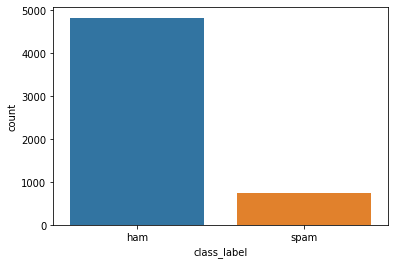

In [8]:
sns.countplot(data['class_label'])

In [9]:
for i in range(data.shape[0]):
    if(data['class_label'][i]=='ham'):
        data['class_label'][i]=1
    else:
        data['class_label'][i]=0

In [10]:
data.head()

,class_label,message
0,1,"Go until jurong point, crazy.. Available only ..."
1,1,Ok lar... Joking wif u oni...
2,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor... U c already then say...
4,1,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [12]:
data_ham  = data[data['class_label'] == 1].copy()
data_spam = data[data['class_label'] == 0].copy()

In [15]:
data_ham

,class_label,message
0,1,"Go until jurong point, crazy.. Available only ..."
1,1,Ok lar... Joking wif u oni...
3,1,U dun say so early hor... U c already then say...
4,1,"Nah I don't think he goes to usf, he lives aro..."
6,1,Even my brother is not like to speak with me. ...
...,...,...
5565,1,Huh y lei...
5568,1,Will �_ b going to esplanade fr home?
5569,1,"Pity, * was in mood for that. So...any other s..."
5570,1,The guy did some bitching but I acted like i'd...


In [16]:
def show_cloud(df, title):
    text = ' '.join(df['message'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()

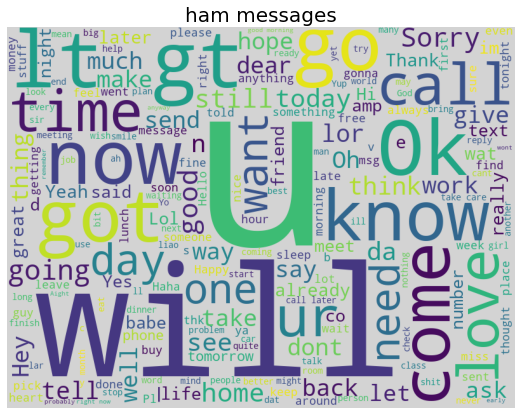

In [17]:
show_cloud(data_ham,"ham messages")

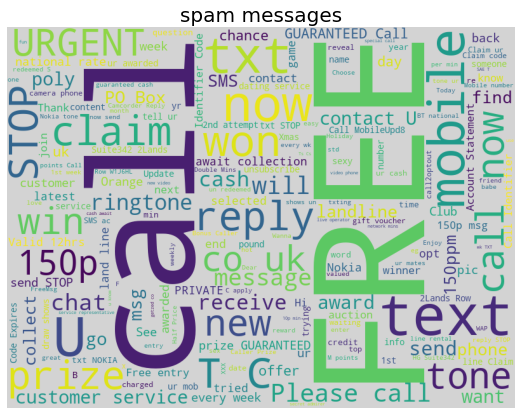

In [18]:
show_cloud(data_spam,"spam messages")

In [19]:
# helps in text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# helps in model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

# split data into train and test set
from sklearn.model_selection import train_test_split

In [20]:
X = data['message'].values
y = data['class_label'].values


In [21]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [22]:
from nltk.stem import PorterStemmer

In [23]:
stemmer=PorterStemmer()

In [24]:

l=[]
import re
stop_words=set(stopwords.words('english'))
for sen in X:
    res = re.sub(r'[^a-z A-Z^]', '', sen)
    res=res.lower()
    res=res.split()
    words=[w for w in res if not w in stop_words]
    stemmed_words=[stemmer.stem(w) for w in words]
    sentence=" ".join(stemmed_words)
    
    l.append(sentence.lower())

In [25]:
len(l)

5572

In [26]:
vocab_size=9000
max_length=10

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
onehot_data=[one_hot(words,vocab_size) for words in l]

In [28]:

padded_data = pad_sequences(onehot_data, maxlen=max_length, padding='post')
print(padded_data)

[[8236 8768 2688 ... 1005  510  744]
 [6306 7184 3912 ...    0    0    0]
 [7834  419 6248 ... 5524 7977 4541]
 ...
 [5837  986 7485 ...    0    0    0]
 [8613 4671  494 ... 5007 6352 6935]
 [5938 4295 8078 ...    0    0    0]]


In [29]:
X_final=np.array(padded_data)
y_final=np.array(y)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=42)


<AxesSubplot:ylabel='count'>

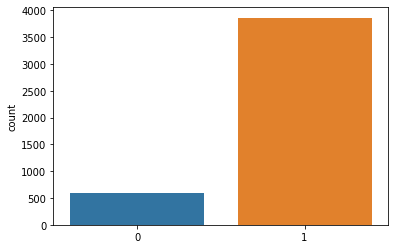

In [31]:
#plotting training data
sns.countplot(y_train)

In [32]:
y_train

array([1, 0, 1, ..., 1, 1, 1], dtype=object)

In [33]:
x_train=tf.convert_to_tensor(X_train, dtype=tf.int64)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int64) 
x_test=tf.convert_to_tensor(X_test, dtype=tf.int64)
y_test=tf.convert_to_tensor(y_test, dtype=tf.int64)

In [34]:
print(y_train)

tf.Tensor([1 0 1 ... 1 1 1], shape=(4457,), dtype=int64)


In [35]:


# define the model 
model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 24)            216000    
_________________________________________________________________
flatten (Flatten)            (None, 240)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               120500    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               100200    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [36]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [37]:
# fit the model
model.fit(x=X_train,
         y=y_train,
         epochs=50,
         validation_data=(X_test, y_test), verbose=1,
         callbacks=[early_stop]
         )

Epoch 1/50
140/140 [==============================] - 1s 4ms/step - loss: 0.1530 - accuracy: 0.9432 - val_loss: 0.0710 - val_accuracy: 0.9821
Epoch 2/50
140/140 [==============================] - 0s 3ms/step - loss: 0.0397 - accuracy: 0.9874 - val_loss: 0.0836 - val_accuracy: 0.9785
Epoch 3/50
140/140 [==============================] - 0s 3ms/step - loss: 0.0157 - accuracy: 0.9960 - val_loss: 0.1183 - val_accuracy: 0.9731
Epoch 4/50
140/140 [==============================] - 0s 3ms/step - loss: 0.0051 - accuracy: 0.9989 - val_loss: 0.1669 - val_accuracy: 0.9731
Epoch 5/50
140/140 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.2251 - val_accuracy: 0.9722
Epoch 6/50
140/140 [==============================] - 0s 3ms/step - loss: 4.9340e-05 - accuracy: 1.0000 - val_loss: 0.3059 - val_accuracy: 0.9578
Epoch 7/50
140/140 [==============================] - 0s 3ms/step - loss: 1.4418e-06 - accuracy: 1.0000 - val_loss: 0.3860 - val_accuracy: 0.972

In [38]:
y_pred=(model.predict(x_test) > 0.5).astype("int32")


In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def c_report(y_true, y_pred):
       print("Classification Report")
       print(classification_report(y_true, y_pred))
       acc_sc = accuracy_score(y_true, y_pred)
       print("Accuracy : "+ str(acc_sc))
       return acc_sc

def plot_confusion_matrix(y_true, y_pred):
       mtx = confusion_matrix(y_true, y_pred)
       sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
                   cmap="Blues", cbar=False)
       plt.ylabel('True label')
       plt.xlabel('Predicted label')

In [40]:
c_report(y_test, y_pred)

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       150
           1       0.98      0.99      0.98       965

    accuracy                           0.97      1115
   macro avg       0.95      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Accuracy : 0.9713004484304932


0.9713004484304932

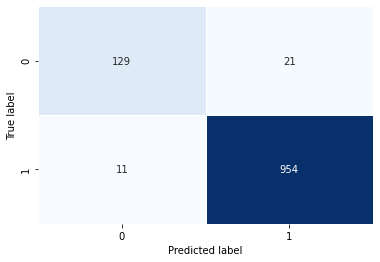

In [41]:
plot_confusion_matrix(y_test, y_pred)